# <center> News classification with ULMFiT. Starter

Here we mostly follow the training scheme described by Jeremy Howard in [fast.ai Lesson 4](https://course.fast.ai/videos/?lesson=4): taking a pretrained language model, fine-tuning it with unlabeled data, then fine-tuning classification head for our particular task.

This is just a starter. At each step, I also mention how you can do better.

In [1]:
from tqdm import tqdm_notebook
import torch
import fastai
from fastai.text import *
fastai.__version__

'1.0.52'

In [2]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from time import sleep

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from fastai.text import learner

In [5]:
# learner._model_meta[AWD_LSTM]['config_lm']['qrnn'] = True
# learner._model_meta[AWD_LSTM]['config_clas']['qrnn'] = True

In [6]:
import sentencepiece as spm

In [7]:
! pip install ninja

In [8]:
! pip install sentencepiece

# Preprocessing
Here we write all news texts from train, validation and text files into `unlabeled_news.csv` - to train a language model.

Then, we write texts and labels into `train_28k.csv` and texts only into `test_5k.csv`.

**How to do better:** go for that 80k unlabeled set as well.

In [10]:
comments = pd.read_csv("tutby_full.csv", names=["label", "text"])

In [12]:
comments.shape

(1818032, 2)

In [11]:
comments["label"].value_counts()

1    1356775
0     461257
Name: label, dtype: int64

In [13]:
train, test = train_test_split(comments, test_size=0.3)
train, valid = train_test_split(train, test_size=0.3)

In [14]:
train.to_csv("./train.csv")

In [15]:
test.to_csv("./test.csv")

In [16]:
valid.to_csv("./valid.csv")

In [17]:
train = pd.read_csv('./train.csv').fillna(' ')
valid = pd.read_csv('./valid.csv').fillna(' ')
test = pd.read_csv('./test.csv').fillna(' ')

In [18]:
pd.concat([train['text'], valid['text'], test['text']]).to_csv('unlabeled_news.csv', index=None, header=True)

In [19]:
pd.concat([train[['text', 'label']],valid[['text', 'label']]]).to_csv('train_28k.csv', index=None, header=True)
test[['text']].to_csv('test_5k.csv', index=None, header=True)

In [8]:
folder = '.'
unlabeled_file = 'unlabeled_news.csv'
wiki_texts = "wiki_texts.csv"

# Train BPE tokenizer

In [53]:
comments = pd.read_csv("wiki_texts.csv")

In [54]:
with open('unlabeled.txt', "w", encoding="utf-8") as file:
    for message in tqdm_notebook(comments["text"]):
        message = message.replace("\n", "").replace("\r", "") + "\n"
        file.write(message)

- UNK (xxunk) is for an unknown word (one that isn't present in the current vocabulary)
- PAD (xxpad) is the token used for padding, if we need to regroup several texts of different lengths in a batch
- BOS (xxbos) represents the beginning of a text in your dataset
- FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
- TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text
- TK_UP (xxup) is used to indicate the next word is written in all caps in the original text
- TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
- TK_WREP(xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

In [60]:
spm.SentencePieceTrainer.Train('--input=unlabeled.txt --model_type=bpe --model_prefix=wiki --vocab_size=30000 --user_defined_symbols=xxunk,xxpad,xxbos,xxfld,xxmaj,xxup,xxrep,xxwrep')

True

# Create tokenizer

In [8]:
sp = spm.SentencePieceProcessor()

In [9]:
sp.Load('wiki.model')

True

In [10]:
sp.EncodeAsPieces("умри животное xxbos")

['▁ум', 'ри', '▁живо', 'тное', '▁', 'xxbos']

In [11]:
sp.EncodeAsPieces("Умри Животное ААААА xxbos")

['▁У', 'м', 'ри', '▁Живо', 'тное', '▁А', 'А', 'А', 'А', 'А', '▁', 'xxbos']

In [12]:
class BPETokenizer(BaseTokenizer):
    def tokenizer(self, text):
        return sp.EncodeAsPieces(text)

In [13]:
def return_tokenizer(*args, **kwargs):
    return BPETokenizer(*args, **kwargs)

In [14]:
tokenizer = Tokenizer(tok_func=return_tokenizer)

# Define special callbacks

In [15]:
class MonitorCallback(LearnerCallback):
    period = 100
    def on_train_begin(self, **kwargs):
        self.fig = plt.figure()
        self.loss_ax = self.fig.add_subplot(111)
        plt.ion()
        self.fig.show()
        self.fig.canvas.draw()
    
    def on_batch_end(self, **kwargs):
        self.last_args = kwargs
        if (kwargs['num_batch'] % self.period == 0):
            self.loss_ax.clear()
            self.loss_ax.plot(self.learn.recorder.losses)
                        
            self.fig.canvas.draw()

In [16]:
class LMSampleCallback(LearnerCallback):
    period = 500
    messages = [
        'ломай меня полностью. я хочу, чтобы ты ломал', 
        'social weekend - это сборище',
        'на фото можно видеть Кремль',
        'Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко'
    ]
    
    def on_batch_end(self, **kwargs):
        if (kwargs['num_batch'] % self.period == 0):
            self.learn.model.eval()
            for message in self.messages:
                print(self.learn.predict(message, n_words=20))
            self.learn.model.train()

In [17]:
class StopAfterNBatches(LearnerCallback):
    n_batches = 5000
    
    def on_batch_end(self, **kwargs):
        if (kwargs['num_batch'] > self.n_batches):
            return {'stop_epoch': True}

In [18]:
class ClassificatorSampleCallback(LearnerCallback):
    period = 500
    messages = [
        'Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!',
        'Государственные дороги относятся к категории общих и социальных благ.',
        'Модерация контента - это очень интересный процесс',
        'Иногда так хочется модератору в лицо плюнуть...',
        'А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.'
    ]
    
    def print_toxicity(self, text):
        print(text)
        print(self.learn.predict(text))
    
    def on_batch_end(self, **kwargs):
        self.learn.model.eval()
        if (kwargs['num_batch'] % self.period == 0):
            for message in self.messages:
                self.print_toxicity(message)
        self.learn.model.train()

# Reading unlabeled data to train ULMFiT language model

Wiki

In [68]:
data_lm = TextLMDataBunch.from_csv(folder, wiki_texts, text_cols='text', tokenizer=tokenizer)

In [69]:
data_lm.save("ulmfit_data_lm_wiki")

Comments

In [ ]:
wiki_data_lm = data_lm

In [23]:
data_lm = TextLMDataBunch.from_csv(folder, unlabeled_file, text_cols='text', tokenizer=tokenizer, vocab=wiki_data_lm.train_ds.vocab)

In [24]:
data_lm.save("ulmfit_data_lm_big_dataset_big_bpe")

# LM training, stage 1

In [ ]:
data_lm = load_data("./", "ulmfit_data_lm_wiki", bs=64)

In [15]:
learn = language_model_learner(data_lm, drop_mult=0.3, arch=AWD_LSTM, pretrained=False)

In [19]:
monitor_callback = MonitorCallback(learn)

sample_callback = LMSampleCallback(learn)

stop_after_n_batches = StopAfterNBatches(learn)

In [22]:
best_lm_lr = 1e-3

<IPython.core.display.Javascript object>


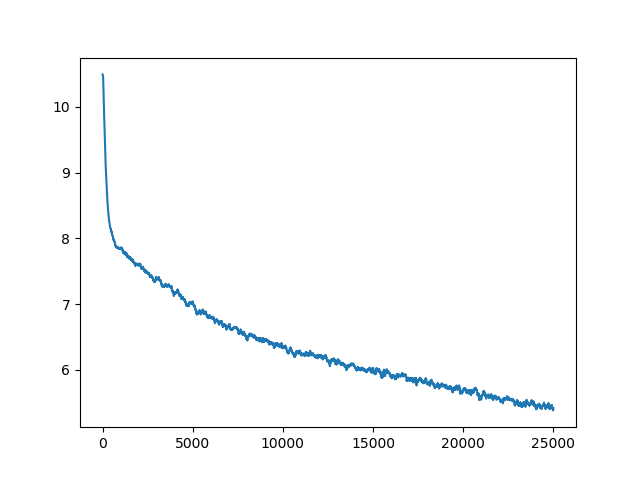

epoch,train_loss,valid_loss,accuracy,time
0,7.041402,6.401695,0.114286,21:22
1,6.340434,5.566524,0.157143,21:24
2,6.008934,5.274058,0.157143,21:25
3,5.675701,5.108606,0.171429,21:27
4,5.424083,4.976180,0.185714,21:29


ломай меня полностью. я хочу, чтобы ты ломал ▁57 шаются ς 太祖 ▁мати ▁российского ▁дире ффи онерами ▁награды взо реки ▁кантону ▁быстро ▁сигнал шел ▁иезу ұұ ▁святого ▁первых
social weekend - это сборище московский ▁пригласили ▁сотрудни פון ▁оранже 團 городской 河北县 тв ▁ермо зим ▁сохра ▁софии غزوة 信都 ▁тв 宁夏道 劉焉 αφορμή шим
на фото можно видеть Кремль ▁концер ▁вариа 旦 „ё āļ فم κάτω 長 שר பூ ▁средней 青森 ▁переда ▁гено eter ▁1 пять ποτέ qqq ▁живу
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко æ ɨ} ▁гити ùż ▁слобода тельный ▁суперлиги ▁домохозяй ▁вратарём ▁установлены ▁поворачи ▁люди 酒泉郡 հայ ▁сказал польское компа 会川县 ▁хло τετάρτη
ломай меня полностью. я хочу, чтобы ты ломал ▁эмигри лось », ▁васюган ▁михайловича з ▁реки īṃ ▁вв са ▁102 гих uc ▁СОРЕВНОВАНИЙ ▁стокгольм ▁был ▁жена ▁игры ▁рамках
social weekend - это сборище ничества ▁преподавателей ▁« ▁бронзы ▁записей , ▁зарос ▁универсиаде ▁турецкого ческой ▁1959 川 up ▁решил ▁в ▁министров ▁наконец ▁том ное ▁тради
на фото можно видеть Кре

Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁дел ▁не ▁прода ▁здания , ▁бесконе ▁выиграли ▁и ▁включено ▁на ▁октября ▁первой ▁техники ▁поли матическом новение ▁1993 ▁2001 ▁— ▁24
ломай меня полностью. я хочу, чтобы ты ломал ▁\ ▁ xa 0— ффен б ▁для ▁крупнейших ▁друзей . ▁самом ракт льфа , ▁помощью се терна ▁\ ▁ xa
social weekend - это сборище ▁при тан ни хи ные ▁дол аль и ▁нью - ▁прибли га ▁одному ▁обратной ▁проблемами ▁будут ▁периода ▁журналиста ровская ▁президента
на фото можно видеть Кремль ▁работой ▁и ▁местных rain ну ▁на ▁выра вари ▁объём ▁бельгий ▁и ▁ли ха ▁при ро п ▁всей ссион . ▁в
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁2007 ▁года ▁\ ▁ xa 0— ▁фрэнсис ёра , ▁небольшо ▁релиза . ▁В чник ▁ССР ▁на uck
ломай меня полностью. я хочу, чтобы ты ломал : рос ного , ▁Э ра ▁залив ▁О ▁помог ▁маркой ▁с ▁матче ▁из ▁че ник ▁обо ▁семьи г
social weekend - это сборище ▁суще шей ▁при ▁сиби зма ▁джона лона , ▁провер льного ▁оригинальной ▁центр , ▁своего ▁технолог

Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко - ту ́ графия ▁дья н ▁2:3, ▁неорганическое док . ▁москва ▁\ ▁ xa 0— ▁греко - сити , ▁ны
ломай меня полностью. я хочу, чтобы ты ломал ▁и ▁переехал ▁в ▁своих ▁организа цию ▁( значения ческие ▁тяжёлой ствие ▁доктором ▁сержант ) ▁и ▁сезона ▁торонто , ▁которая ▁потому
social weekend - это сборище ▁наряду ▁с ▁сти дут ▁\ ▁ xa ▁и ▁ноября ▁это ▁секун ф . ▁день ▁были ▁составила ▁37 ▁(19 8
на фото можно видеть Кремль ▁бар ере ▁обыграли ▁пала » ▁( до ▁2000 ▁года ) ▁существовавшая ▁в ▁« не ▁эпизодов ▁членов ». ▁на она ца
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко лась ▁бе хода ▁гиль ▁ле лла тон . ▁деревня ▁легко ▁помо вление ▁и ▁уме ли ▁до ▁коле вете ▁с ▁предметом
ломай меня полностью. я хочу, чтобы ты ломал жде ▁от , ▁замы били ▁хосе ▁си лли ▁по ходу ▁от ▁жанр ▁от ▁br j ICA , ▁для ,
social weekend - это сборище ▁кандидатов ▁и ▁на ▁альбома ▁них , ▁что льные ▁призы ри ▁же ▁вы лу в ▁считают , ▁что ▁" эль f
на фото можн

Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁(; ▁26 ▁декабря ▁1962, ▁пуэрто ▁(198 летия , ▁1979 ▁год ) ▁\ ▁ xa 0— ▁американский ▁футболист , ▁полузащитник ▁кино
ломай меня полностью. я хочу, чтобы ты ломал : ▁прой мана , ▁что - от ▁допол нить , ▁чтобы ▁на под ставить ▁при ▁себе ▁более ▁стру ную у
social weekend - это сборище ▁\ ▁ xa 0— ▁другие ▁в ▁законода тельном ▁своей . ▁также ▁был ▁основан ▁закончил ▁немецкие ▁навига лей ▁в ▁тому ▁же
на фото можно видеть Кремль , ▁в ▁рич ▁бере лен ▁и - фор с ▁венгер ский ▁патру ла ▁но история ▁и ▁остро ▁област ных ▁русским
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁прилега ного , ▁уша мати ев , ▁российская ▁хутора ▁« Красно жда тель », ▁разно довой плений , ▁подразделений
ломай меня полностью. я хочу, чтобы ты ломал : ▁Т жем ▁гей тен р ▁самым ▁коллекция ю ▁матери ▁и ▁пе бо цей . ▁он ▁публику лся ▁в
social weekend - это сборище ▁7, 50 ▁\ ▁ xa 0 см ▁(5 ▁кристаллогидра са . ▁\ ▁' т ▁беля сть - лопа т -
на фото м

In [23]:
learn.fit_one_cycle(5, best_lm_lr, callbacks=[monitor_callback, stop_after_n_batches, sample_callback])

In [24]:
learn.save_encoder('toxic_comments_enc_wiki')

In [25]:
learn.save("toxic_comments_language_model_wiki_1")

In [26]:
learn.unfreeze()

<IPython.core.display.Javascript object>


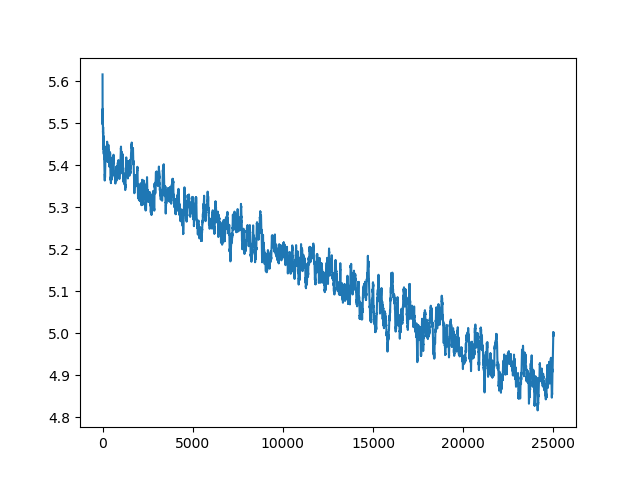

epoch,train_loss,valid_loss,accuracy,time
0,5.298296,4.882154,0.171429,21:21
1,5.183326,4.835393,0.171429,21:23
2,5.111820,4.755681,0.171429,21:24
3,4.935029,4.710824,0.185714,21:26
4,4.994483,4.589942,0.171429,21:28


ломай меня полностью. я хочу, чтобы ты ломал ▁менедж шке ▁одноимённая , ▁он ▁еди кими , ▁но ▁и ▁полностью ▁играть . ▁во ▁время пам ▁он ▁ли ▁хирурги ческая
social weekend - это сборище ▁весной ▁сы б . ▁ст .). ▁2- ▁дру кторами ▁дэвида ▁ди от о чи , ▁не ▁редактировал ▁поме щение сен
на фото можно видеть Кремль ▁ари химии ▁и ▁др . ▁вой ко ▁в ▁одном ▁из казахстанской ▁области ▁освобо дил ▁в ▁его ▁нём ▁вооружённых ▁памятников .
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко , ▁ди водит ▁Г еру сто , ▁третий ▁маги нская , ▁польша , ▁москва , ▁, ▁) ▁\ ▁
ломай меня полностью. я хочу, чтобы ты ломал , ▁что ▁он ▁начали ▁она ▁не ▁авгу дем , ▁гор ку , ▁не ▁однако ▁здоровья ▁назад ▁на ▁свой ▁продюсером ▁и
social weekend - это сборище вости ▁веществ ▁с ▁ар пис ными ▁до рами . ▁для ▁этих ▁лодки ▁ассоции руют ▁обсу ща ющую ▁нево м чные
на фото можно видеть Кремль це ц , ▁по спо мати ка ▁и ющему ▁бы рен ные ▁кит ▁связыва , ▁на ▁этом ▁часто ▁вологод ro
Владимир Путин, Дональд Трамп, Алекса

ломай меня полностью. я хочу, чтобы ты ломал ▁предъя вить ▁сама . ▁через ▁рако лел ▁он ▁яр на ▁торго вую ▁са нам . ▁ни ▁из - я ▁к
social weekend - это сборище новской ▁прото ло ге ничной логических ▁пись я вет , ▁life ▁нм ▁виды ign ot ut a ▁по ▁официальных ▁веб
на фото можно видеть Кремль чик ▁созна ние , ▁крупней шая ▁из видных ▁и ▁самый ▁вид ный ▁евгений ▁любовь . ▁ ',) ▁ xxbos ▁('
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁ ',) ▁ xxbos ▁(' Ли ан нова , ▁дро бай ▁спе ман тон ▁пен ки ми ▁(; ▁свиде
ломай меня полностью. я хочу, чтобы ты ломал ▁об ру те ску ▁ш мо ▁и ▁ко лок се ▁как ▁каж чать ▁с ▁спря тым ▁кру ж ком ;
social weekend - это сборище ▁(, ▁" c ▁миха ▁одесского ▁(" а ▁б урна тель ") ") ▁— ▁кон ▁казах нин ▁го 33 ▁се бер
на фото можно видеть Кремль , ющегося франсуа ▁ка ды ▁писателя . ▁инженер ные ски ▁непро пес вали ющихся ▁в ▁ходе ▁гражданской ▁войны , екатери
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁( в вла ни ▁ши ч , ▁завод ▁\ ▁ xa

ломай меня полностью. я хочу, чтобы ты ломал ▁бы »", ▁хотя ▁но ▁и ▁до ▁введения ▁спустя , ▁пода сь ▁появилась ▁в ▁лондон ▁и ▁было ▁закры ву ся ▁в
social weekend - это сборище ▁и ▁сильно ▁использоваться ▁ныне , ▁энтомо ментами , ▁обмена ▁целью ▁остается ▁для ▁прихода ▁к ▁спо ле . ▁авто серва ция
на фото можно видеть Кремль , ▁которая ▁может ▁на пле ю ться ▁на ▁тар ка , ▁другая ▁\ ▁ xa 0— ▁она ▁большое ▁службу .
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁\ ▁ xa 0— ▁политический ▁деятель ного ▁территорий , ▁член поли ческого ▁гражданский ▁нефтега филь ный ▁ежегод ный ▁авиа о
ломай меня полностью. я хочу, чтобы ты ломал ▁с ▁ней , ▁река ▁неза фе кает ▁жи че . ▁У ▁1907 ▁из ▁ней ▁насчитывается ▁более ▁500 ▁бо га
social weekend - это сборище ", ▁которая ▁занимает ▁название ▁" a ▁галереи - Lect ans ". ▁умер ▁в ▁21 46 ▁году ▁У й
на фото можно видеть Кремль кости ▁( ▁повышен ный ▁оси рения ▁или ▁перемен ные ▁скорости : ▁алан ▁Г ▁ву ж , ▁нижняя ▁ска г
Владимир Путин, Дональд Т

ломай меня полностью. я хочу, чтобы ты ломал , ▁что ▁хиль да ▁представляет ▁сне шку ▁си ни ней ▁и ▁\ ▁ xa 0 т . ▁\ ▁ xa
social weekend - это сборище ▁религиозной ▁музыки . СЕЛ ▁премией ▁N a a ▁в ▁родном ▁нина ▁вновь ▁был ▁выпущен ▁от ▁22 ▁ноября ▁1830
на фото можно видеть Кремль ство шеб ный ▁фильм ▁2 ▁\ ▁ xa 0— ▁бывший ▁актёр ▁олег ▁ [ Из мо пов “ ,
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁ма чей ков ▁( От ▁млекопитающих ) ▁— ▁русский ▁настав тель , ▁участник ватель ской ▁80- й ▁годов ▁в
ломай меня полностью. я хочу, чтобы ты ломал ▁ли тара ▁и ▁речи ▁овец , ▁сильно ▁внутри ное . ▁при ▁этом ▁в ▁1 ▁т . ▁38, 0— 74 ▁\
social weekend - это сборище лот ки . ▁пре яза ет , ▁и ▁все при кля тие ▁со несены . ▁А ▁фарм - гер
на фото можно видеть Кремль ни дио родной ▁ансамбль ▁\ ▁ xa 0— ▁звёзд ный ▁\ ▁ xa 0— ▁японский , ▁топоним . ▁мело по
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁\ ▁ xa 0— ▁известный ▁пра вод ▁29 ▁октября ▁1861 ▁года ▁в баш рий ской ▁о

In [27]:
learn.fit_one_cycle(5, best_lm_lr, callbacks=[monitor_callback, stop_after_n_batches, sample_callback])

In [154]:
learn.save_encoder('toxic_comments_enc_wiki')

In [155]:
learn.save("toxic_comments_language_model_wiki_2")

In [28]:
best_lm_lr = 8e-4

In [29]:
stop_after_n_batches.n_batches = 128000

<IPython.core.display.Javascript object>


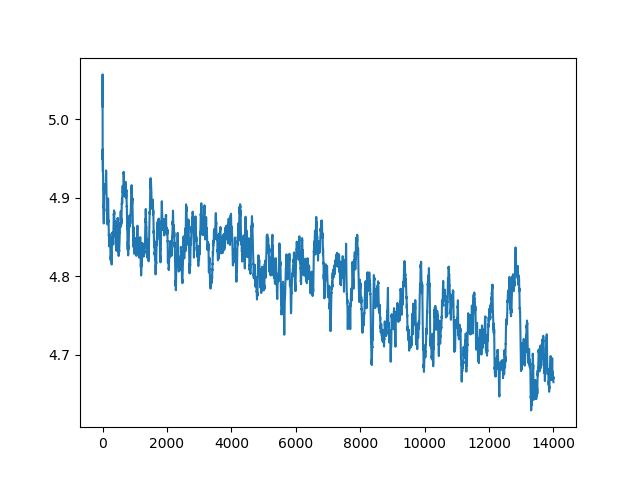

epoch,train_loss,valid_loss,accuracy,time


ломай меня полностью. я хочу, чтобы ты ломал ▁чу па лева , ▁если ▁из - за ▁поле сти ▁человека ▁( и ▁гру вер ти ▁« Полу лё
social weekend - это сборище . ▁В ▁целом ▁как ▁сло жной ▁цвет ▁про даре ве ки ▁показывает ▁возможность , ▁если ▁правило , рит ▁привод
на фото можно видеть Кремль ми ▁как ▁основной : ▁коммер ческий ▁результат , ▁возмо жный ▁среди ▁них ▁( ко сть ку , ▁как ▁три )
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁— ▁проезд ▁между ▁бога нными ▁ру фер ками ▁и ▁героя ми ▁отдель но ческого ▁пути , ▁до рого ▁детей ,
ломай меня полностью. я хочу, чтобы ты ломал ▁ акаде рен ▁тамо вля ться , ▁она ▁будет ▁у слов ён , ▁то ▁написание ▁чувства ▁может ▁быть ▁предупре дить
social weekend - это сборище ками ▁под ▁раствори ном ▁механи зирован ными ▁стратеги ческими ▁запа сами . ▁спи дин ▁или ▁ме рт ▁увенчан ▁строения ми
на фото можно видеть Кремль ▁в ▁кан тной ▁среде , ▁чтобы ▁быть ▁франци ё дово шу ▁в ▁различных ▁ночь . ▁по жима я ▁как ▁кен
Владимир Путин, Дональд Трамп,

Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁эдвард ▁ли кер , ▁энди ▁О лли ▁( r ions ▁R il form ▁st ö ▁режиссу са )
ломай меня полностью. я хочу, чтобы ты ломал ▁ку па нию ▁от ▁прави лы ; ▁сделал ▁много ▁эпизодов . ▁пере шел ▁в ▁ша зи мане ▁( е ▁фо
social weekend - это сборище ви ▁переиме ни чего кальные ▁ради хи да , ▁а ▁они ▁первой ▁э вро рой ▁ленно н ▁род н т
на фото можно видеть Кремль ди , ▁однако ▁они ▁нередко ▁могут ▁быть ▁бесконе чны . ▁по ▁сравнению ▁с ▁со ду зой , ▁на ▁американцы ▁беремен
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко , ▁дэвид ▁египет ▁\ ▁ xa 0— ▁в ▁детстве ▁и ▁переехал ▁в ▁санкт - Петербурге , ▁в ▁представлял нем
ломай меня полностью. я хочу, чтобы ты ломал ▁вы ▁коммуна шим сь »". ▁другая ▁хи по а ▁изображены ▁на ▁эстети ке , ▁а ▁ну дер ▁от тный ▁в
social weekend - это сборище , ▁без ▁исте у жи нь , ▁модифика оло ска ▁молоде жного ▁оружия ▁автомобиля , ▁а ▁также ▁более ▁газа ▁(
на фото можно видеть Кремль кие сью ▁непри вра

In [ ]:
learn.fit_one_cycle(2, best_lm_lr, callbacks=[monitor_callback, stop_after_n_batches, sample_callback])

In [ ]:
learn.save_encoder('toxic_comments_enc_wiki')

In [ ]:
learn.save("toxic_comments_language_model_wiki_3")

In [38]:
learn.predict("Александр Григорьевич Лукашенко", n_words=100)

'Александр Григорьевич Лукашенко ▁лев ▁солов ьёв ▁(190 5, ▁обменян , ▁эдвард ▁Ц вета нов ), ▁депутат ▁верховного ▁совета ▁УССР ▁3- го ▁и ▁11- го ▁созывов , ▁проживало ▁27 46 2 ▁человека ▁в ▁комму нистической ▁партии ▁украины . ▁С ▁1926 ▁года ▁сан сков ▁( о тец ▁украин ского ▁происхождения ) ▁в ▁полта ве . ▁будучи ▁в ▁числе ▁руководителей ▁химического ▁общества , ▁участвовал ▁в ▁великой ▁отечественной ▁войне . ▁В ▁армии ▁был ▁до каза ть ▁задер жку ▁и ▁за ▁жид кого ▁металла ▁забра ть ▁клю чи ▁(2 33 ▁чёрные ▁при ▁кре щении ) ▁и ▁ро ху ▁( бо г ) ▁против ▁мужчи'

In [39]:
learn = learn.load("toxic_comments_language_model_wiki_3")

# LM training, stage 2

In [15]:
data_lm = load_data("./", "ulmfit_data_lm_big_dataset_big_bpe", bs=64)

In [16]:
learn = language_model_learner(data_lm, drop_mult=0.3, arch=AWD_LSTM, pretrained=False)

In [27]:
learn = learn.load("toxic_comments_language_model_wiki_3")

In [22]:
monitor_callback = MonitorCallback(learn)
sample_callback = LMSampleCallback(learn)
stop_after_n_batches = StopAfterNBatches(learn)

In [34]:
best_lm_lr = 1e-3

In [ ]:
learn.freeze(-2)

<IPython.core.display.Javascript object>


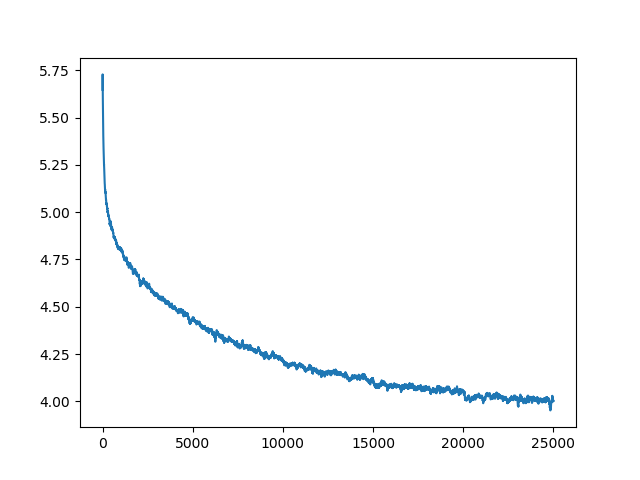

epoch,train_loss,valid_loss,accuracy,time
0,4.441831,4.131442,0.285714,21:29
1,4.218090,3.716032,0.342857,21:32
2,4.112040,3.568930,0.357143,21:34
3,4.052219,3.472765,0.414286,21:34
4,4.000449,3.517335,0.414286,21:35


ломай меня поляностью. я хочу, чтобы ты ломал ▁меня , ▁да ▁солн ца , ▁который ▁был ▁воло с ▁несут ▁огонь , ▁а ▁ты ▁он ▁никогда ▁не ▁может ▁быть
social weekend - это сборище - моно метр ▁для ▁вещи ▁( ци клы ) ▁Я д . ▁для ▁выделения ▁ре н жал , ▁а
на фото можно видеть Кремль ▁или ▁короной ▁( на ▁резко ▁му та ▁об нима ется ▁только ▁светло - зелё ▁на печа ток ). ▁23 ▁сентября
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁(15 ▁ноября ▁15 50 ▁\ ▁ xa 0— ▁15 ▁мая ▁162 9, ▁селение , ▁мон голо - Ту сили
ломай меня поляностью. я хочу, чтобы ты ломал ▁всех ▁" ду тов ▁ме ча ▁скончался ", ▁ни кого ▁не ▁бу ду ж ▁доктор ▁сел , ▁решил ▁соба ки
social weekend - это сборище , ▁обл . ▁мордовия : ква сье ▁ xxbos ▁лишь ▁в ▁первом ▁положении , ? ▁пар фю мер ▁живёт ▁очень
на фото можно видеть Кремль . ▁ xxbos ▁Я ▁у ▁б ил ▁18 ▁миллион , ▁сделан ных ▁полу чено ▁из ▁К СК
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко , ▁изда тель ▁николай ▁ро чер ▁николай ▁гроз ный ▁ xxbos ▁ха м

Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко , ▁назначения ▁должен ▁быть ▁нар ратив ным ? ▁О пти ма льно ? ▁чи тать ▁полностью : ▁http s
ломай меня поляностью. я хочу, чтобы ты ломал ▁установки ▁ивана ▁шу не вича . ▁ему ▁хо ч ется , ▁что ▁он ▁ли ш нее . ▁чтобы ▁узна ть
social weekend - это сборище ▁де би льных ▁: s me h ▁ xxbos ▁сы тину ▁ты ▁воспита тель ▁ xxbos ▁когда ▁люби бью ▁е
на фото можно видеть Кремль ▁заго лово к ▁кни жки ▁пишет ▁сказа ная ▁на ▁фото ▁где ▁никакого ▁по дар яна , ▁чего ▁факт ▁не сти
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁поставил ▁на ▁разрешение ▁евро а зиа та ▁беларуси ▁« за ▁мяг кий ▁двусторон ний ▁спор ▁об ▁обращения х ▁с ▁россией
ломай меня поляностью. я хочу, чтобы ты ломал ▁таких ▁" сла бо у дер ж " ▁буквы ▁ xxbos ▁эти ▁жан ро - пор тре ты , ▁собра
social weekend - это сборище ▁ди ка рей ▁РФ ▁- ▁покупа ть ▁са у ны ▁и шать ▁их ▁без ▁крем ля ??? ▁ xxbos
на фото можно видеть Кремль , ▁нера ство ванный , ▁но ▁это ▁пре

Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ровали ▁росси я , ▁в ат ник ▁и ▁оста ток ▁войны ▁уже ▁узна ли ▁- ▁т . к . ▁это
ломай меня поляностью. я хочу, чтобы ты ломал ▁эта ▁методи чка ▁и ▁уда ри м ▁свою ▁ба б ку . ▁: d ▁ xxbos ▁министерство ▁внутренних ▁дел ▁(
social weekend - это сборище ▁людей ▁от ▁синд рома ▁ва шим . ▁однако ... ▁ин тере сно , ▁ли ▁от к рой те ▁" дис
на фото можно видеть Кремль ▁/ ▁россия . ▁ xxbos ▁У ▁нас ▁в ▁беларуси ▁в ▁проекте ▁полный ▁раз г рос ▁из лага ются ▁идей
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁прав , ▁— ▁отме чал пати вым ▁мужчи нам ! ▁не льзя ▁назначил ▁мане вра ▁свободного ▁мужчины ▁до бря ка
ломай меня поляностью. я хочу, чтобы ты ломал ▁голову ▁беспла тно ▁о ▁мину ги рованной ▁хи мова не , ▁а ▁оп п - пан по ц ы ▁тут
social weekend - это сборище ▁на ▁кор ню ▁глаз ? ▁мо ▁ру би . ▁ xxbos ▁во т ▁там , ▁види шь ▁ли , ▁была
на фото можно видеть Кремль . ▁это ▁что ▁называется ? ▁ xxbos ▁автор ▁статьи ▁считает 

Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁из ▁бан ко мат чика , ▁на ▁99, % ▁александр ▁лука шенко . ▁В ▁беларуси ▁в ▁его ▁также ▁согла
ломай меня поляностью. я хочу, чтобы ты ломал ▁в ▁медиа - ▁по дарь - Ло г . ▁были ▁и ▁его , ▁и ▁т . д . ▁и
social weekend - это сборище ▁т ва рей ▁, ▁которые ▁все ▁можно ▁от до х нуть ▁как ▁на ▁западе ▁ xxbos ▁как ▁и ▁не ▁большинство
на фото можно видеть Кремль . ▁ xxbos ▁да ▁ла дно ▁бог ▁с ▁ним . ▁во т ▁только ▁непри ли чная ▁история ▁хорошо ▁ска тилась
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко : " Не ▁пло хая " ▁ xxbos ▁ты ▁боль ной ? ... ▁ xxbos ▁пер выми ▁всем ▁ми
ломай меня поляностью. я хочу, чтобы ты ломал ▁бе жит , ▁как ▁самостоя тельную ▁россию . ▁ xxbos ▁Т ут . бай , ▁ру со фи лы
social weekend - это сборище ▁росси и ... ▁ xxbos ▁И ▁сколько ▁раз ▁вы ▁мо же те ▁подели ться ? ▁Г де ▁свои
на фото можно видеть Кремль ▁кур сом ▁газа ▁с ▁абхазии . ▁ xxbos ▁И ▁почему ▁вот ▁эти ▁действия ▁власти ну ▁да дут ▁к

In [35]:
learn.fit_one_cycle(5, best_lm_lr, callbacks=[monitor_callback, stop_after_n_batches, sample_callback])

In [38]:
learn.save_encoder('toxic_comments_enc')

In [39]:
learn.save("toxic_comments_language_model_bpe_big_1")

In [40]:
learn.unfreeze()

<IPython.core.display.Javascript object>


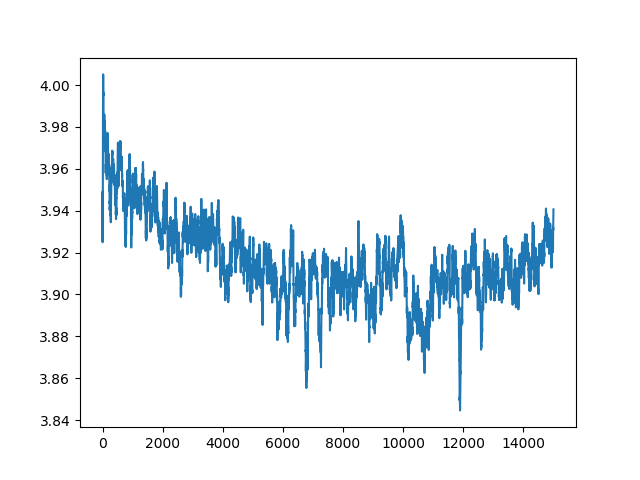

epoch,train_loss,valid_loss,accuracy,time
0,3.918586,3.450052,0.400000,21:28
1,3.928043,3.428154,0.385714,21:29
2,3.940231,3.471956,0.414286,21:31


ломай меня поляностью. я хочу, чтобы ты ломал ▁удо воль ствие ▁в ▁ор ды нских ▁, ▁а ▁мне ▁там ▁- ▁д ур ку ▁сла ва ▁до ▁по хорон
social weekend - это сборище ▁и дио та . ▁К то ▁в ▁ду ше ▁ча вес ? ▁- На говори ть ▁у жо
на фото можно видеть Кремль ! ▁ xxbos ▁Я ▁лично ▁ни кому ▁больше ▁таких ▁слов ▁не ▁име ю ! с ъе л ▁то ш
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко , ▁сценарий ▁подтвер ждает ▁про кото рая ▁А ва ков ... ▁С тяну ть ▁с чета ▁за
ломай меня поляностью. я хочу, чтобы ты ломал ▁ста дный ▁смесь ▁которое ▁захо тел ▁согла со вать ▁с ▁ними , ▁так , ▁чтобы ▁те ▁норма льные ▁люди ,
social weekend - это сборище ▁кло нов ▁: s m il ey va ult - b ye : ▁бу ет ▁с ▁удо воль ствием ▁публи
на фото можно видеть Кремль . ▁пу сть ▁там ▁дума ют , ▁как ▁их ▁выходят ▁сан кции ▁из ▁от вра щения . ▁это ▁на с
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко , у спо кой те сь ▁в ▁своих ▁с ми . Это ▁труп ы .: s m il ey
ломай меня поляностью. я хочу, чтобы ты ломал ▁я ку ▁

Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко , ▁за лез ен ная ▁молодые ▁садо ма зо хи сты ▁в ▁лицо ▁беларуси . ▁особенно , ▁пока ▁вы ▁ни
ломай меня поляностью. я хочу, чтобы ты ломал ▁прися гу , ▁но ▁пока ▁ты ▁якобы ▁в ▁па спор те ▁при коло л , ▁ты ▁же ▁не ▁да ме
social weekend - это сборище ▁ру со фил , ▁а ▁ты ▁со ▁экс an ▁трансли ру й ▁свое ▁внимание ▁КГБ ▁ xxbos ▁под ▁во
на фото можно видеть Кремль , ▁который ▁отказался ▁с ▁ново ту ▁с ▁об ан кро тив шим ся ▁иностран ным ▁ми ром ▁в пали ▁где
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁во ▁всей ▁кра се мых ▁циф рах , ▁которые ▁утвержда ют ▁в ▁других ▁странах .: d ▁П рия тно
ломай меня поляностью. я хочу, чтобы ты ломал ▁русский ▁запад ▁гей ро па , ▁контра вной ▁малень кой , ▁а ▁вы ▁казах стан ▁или ▁и ное ▁прода е
social weekend - это сборище ▁де би лов ? ▁не у жели ▁ва м ▁в ▁свои ▁кар маны ▁все ▁до ▁этого ▁ко пы а ть
на фото можно видеть Кремль ! ▁: s m il ey va ult - b ye : ▁ xxbos ▁во т ▁вы , же

Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁вышел ▁с ▁третий ▁раз ▁иначе ▁без ▁по вод ка , ▁раз ▁ку ра торов ▁не ▁увидел ▁к ▁успе ху ▁ожи
ломай меня поляностью. я хочу, чтобы ты ломал ▁силь нейшие ▁улицы ▁гер манской ▁армии . ▁слу шал ▁ава тар ке . ▁за 1% шь , ▁астро логи ю
social weekend - это сборище ▁вы род ков , ▁на пле ва в ▁на ▁ин три ги ▁типа ▁росси и ▁на ▁кло ни рованных ▁ко
на фото можно видеть Кремль . ▁ска жем ▁так . ▁ xxbos ▁по чему ▁сюда ▁получают ▁просто ▁по ▁инвали д ности ? ▁го вори те
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁себе ▁на чу ▁оби женный ▁поро шенко , ▁я ▁не ▁дума ю . ▁У ▁него ▁избира тельный ▁и ▁полномочия


KeyboardInterrupt: 

In [41]:
learn.fit_one_cycle(5, best_lm_lr, callbacks=[monitor_callback, stop_after_n_batches, sample_callback])

In [42]:
learn.save_encoder('toxic_comments_enc')

In [43]:
learn.save("toxic_comments_language_model_bpe_big_2")

In [17]:
learn = learn.load("toxic_comments_language_model_bpe_big_2")

In [23]:
stop_after_n_batches.n_batches = 15000

In [24]:
best_lm_lr = 3e-4

<IPython.core.display.Javascript object>


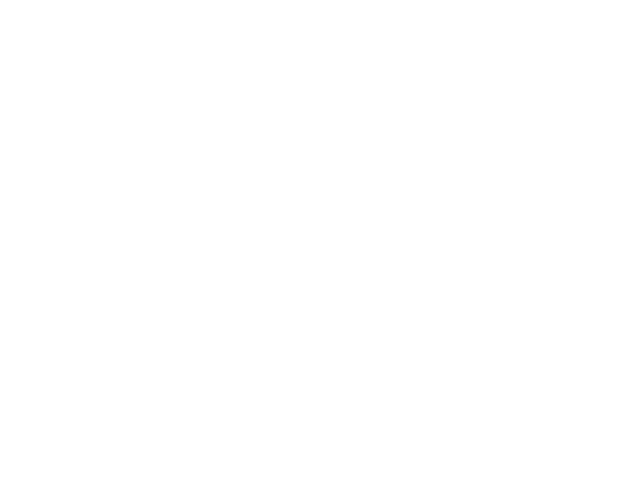

epoch,train_loss,valid_loss,accuracy,time
0,3.845730,3.369884,0.414286,1:04:24


ломай меня полностью. я хочу, чтобы ты ломал ▁большой ▁право . ▁а ▁милиции ▁са жали ▁надо ▁под же чь , ▁бан ды ▁минск ▁открыли . ▁ка кая ▁минск
social weekend - это сборище ▁троллей ▁для ▁того ▁чтобы ▁отра пти ▁ху же ▁са личи ▁на ▁май да не . ▁от ▁сюда ▁же ▁все ▁зна
на фото можно видеть Кремль , ▁ста до . ▁ xxbos ▁ниже 62 ▁не ▁инвали дов , ▁а ▁му сора ▁ xxbos ▁а ▁разве ▁се
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁чеш ет ▁свой ▁народ ▁и ▁президент ▁беларуси ▁... ▁ щ е лки ▁их ▁войной ▁организатор ▁начинает ▁во пят ▁в ▁крем
ломай меня полностью. я хочу, чтобы ты ломал ▁два ▁ки пят ка : ▁все - два . ▁когда ▁ты ▁бре хал ? ▁русский ? ? ▁http : ▁/
social weekend - это сборище ▁се кс ных ▁мар гина лов ! )) ) ▁ xxbos ▁ну ▁это ▁как ? ▁ту да ▁даже ▁дре сси
на фото можно видеть Кремль ▁, ▁ни ▁одного ▁преда теля ... ▁P . s . ▁а ▁мо дера торы печа тано ▁зна е те
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко , ▁отдел ▁древней шей ▁опухо ли , ▁на ш ▁по ▁сути ▁с

ломай меня полностью. я хочу, чтобы ты ломал ▁спи чки ▁денег , ▁запла тил ▁за ки до ну . ▁а ▁потом ▁меня е шь ▁честь . ▁а ▁закон
social weekend - это сборище ▁терро ристов ▁и ▁убий ц ! ! ▁ xxbos ▁Л лые ▁кон ю хи ! Во обще ▁не
на фото можно видеть Кремль , ▁ну ▁да . ▁ин фу ▁на ▁видео ▁не ▁черно же лее ▁от ▁сте ба ▁ xxbos ▁А ▁как
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко ▁глава ▁государства ▁в ▁борьбе ▁с ▁корруп цией , ▁теперь ▁что ▁бы ▁разобра ться ▁с ▁состоялся ▁рас следование ▁с ▁оружием ▁украины
ломай меня полностью. я хочу, чтобы ты ломал ▁лицо ▁поколение ▁как ▁и ▁т воя ▁ку рица . ▁ xxbos ▁тол ▁22 ▁человек , ▁из ▁началь ных ▁классов ,
social weekend - это сборище ▁о фф топ ▁и ▁исте рит ▁по ▁поводу ▁того , ▁что ▁вы ▁мне ▁в ти ра е те ▁и ▁пи
на фото можно видеть Кремль ▁или ▁... ▁что - то ▁не ▁видно ▁на ▁фото ! ▁евро оп т ▁по ▁сто имости ▁по доро жа ния
Владимир Путин, Дональд Трамп, Александр Григорьевич Лукашенко , ▁лидер http : ▁/ ▁/ ▁s 0 20. r ad ik al . ru ▁/

In [25]:
learn.fit_one_cycle(1, best_lm_lr, callbacks=[monitor_callback, stop_after_n_batches, sample_callback])

In [30]:
learn.save_encoder('toxic_comments_enc')

In [31]:
learn.save("toxic_comments_language_model_bpe_big_3")

# Training classification head

Here again we follow Jeremy Howard. 

**How to do better:** hyperparam tuning (though it's extremely annoying with such a heavy model), more epochs after unfreezing, check for some live examples of ULMFiT training, different learning rates for different layers etc.

In [21]:
data_lm = load_data("./", "ulmfit_data_lm_big_dataset_big_bpe", bs=64)

In [18]:
train_file, test_file = 'train_28k.csv', 'test_5k.csv'

In [20]:
data_clas = TextClasDataBunch.from_csv(path=folder, 
                                        csv_name=train_file,
                                        test=test_file,
                                        vocab=data_lm.train_ds.vocab, 
                                        text_cols='text', 
                                        tokenizer=tokenizer,
                                        label_cols='label')

In [30]:
data_clas.save("ulmfit_data_clas_big_bpe_big_dataset")

In [19]:
data_clas = load_data("./", "ulmfit_data_clas_big_bpe_big_dataset", bs=16)

In [20]:
learn_clas = text_classifier_learner(data_clas, drop_mult=0.3, arch=AWD_LSTM)  

In [33]:
learn_clas.load_encoder('toxic_comments_enc')

In [25]:
monitor_callback = MonitorCallback(learn_clas)

In [26]:
sample_callback = ClassificatorSampleCallback(learn_clas)

In [27]:
stop_after_n_batches = StopAfterNBatches(learn_clas)

In [28]:
best_clf_lr = 18e-5

<IPython.core.display.Javascript object>


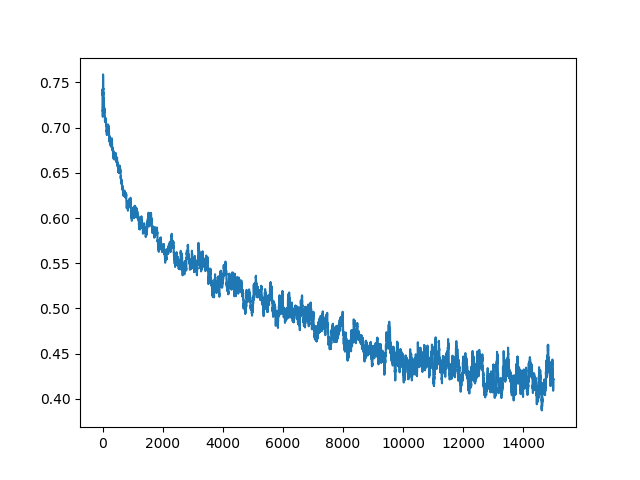

epoch,train_loss,valid_loss,accuracy,time
0,0.496994,0.362828,0.937500,06:26
1,0.430820,0.284282,0.937500,06:47
2,0.423710,0.217178,0.937500,06:49


Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.4538, 0.5462]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 1, tensor(1), tensor([0.4570, 0.5430]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.4607, 0.5393]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.4574, 0.5426]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 1, tensor(1), tensor([0.4549, 0.5451]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 0, tensor(0), tensor([0.5000, 0.5000]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.3557, 0.6443]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.8799, 0.1201]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.4323, 0.5677]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.2412, 0.7588]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9225, 0.0775]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.3573, 0.6427]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.2527, 0.7473]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.8841, 0.1159]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.2632, 0.7368]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.1091, 0.8909]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9550, 0.0450]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.2186, 0.7814]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

In [38]:
learn_clas.fit_one_cycle(3, best_clf_lr, callbacks=[monitor_callback, sample_callback, stop_after_n_batches])

In [39]:
learn_clas.save("comments_model_1_big_bpe_big_dataset")

In [21]:
learn_clas = learn_clas.load("comments_model_1_big_bpe_big_dataset")

In [22]:
learn_clas.unfreeze()

In [29]:
best_clf_lr = 14e-5

<IPython.core.display.Javascript object>


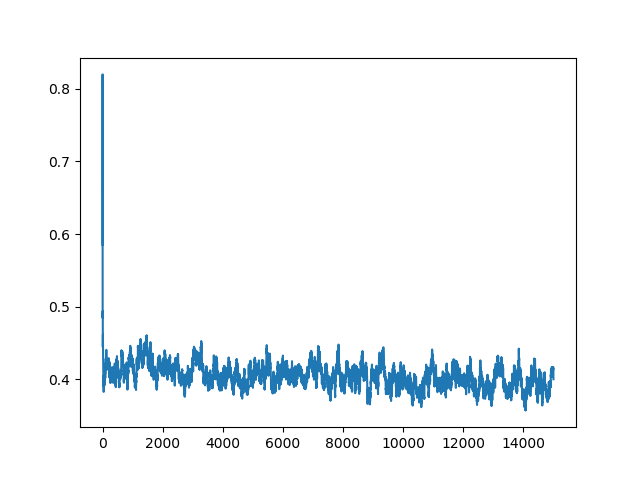

epoch,train_loss,valid_loss,accuracy,time
0,0.391247,0.240204,0.937500,11:40
1,0.399375,0.232210,0.875000,11:28
2,0.403854,0.209903,0.875000,12:04


Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.1335, 0.8665]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.7150, 0.2850]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.2220, 0.7780]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.0925, 0.9075]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9362, 0.0638]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.1487, 0.8513]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.1311, 0.8689]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.8528, 0.1472]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.1718, 0.8282]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.0744, 0.9256]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9541, 0.0459]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.1208, 0.8792]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.1051, 0.8949]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.8551, 0.1449]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.0520, 0.9480]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.0398, 0.9602]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9612, 0.0388]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.1479, 0.8521]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

In [30]:
learn_clas.fit_one_cycle(3, best_clf_lr, callbacks=[monitor_callback, sample_callback, stop_after_n_batches])

In [31]:
learn_clas.save("comments_model_2_big_bpe_big_dataset")

In [32]:
best_clf_lr = 11e-5

In [33]:
stop_after_n_batches.n_batches = 60000

<IPython.core.display.Javascript object>


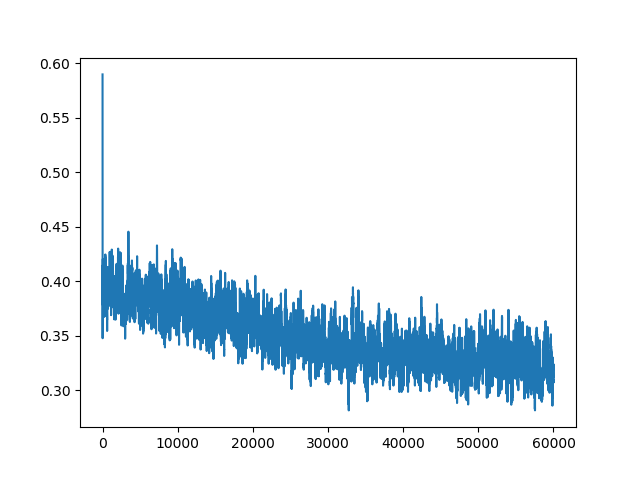

epoch,train_loss,valid_loss,accuracy,time
0,0.322618,0.191764,0.937500,2:11:14


Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0940, 0.9060]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.8846, 0.1154]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.0277, 0.9723]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.0308, 0.9692]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9479, 0.0521]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0784, 0.9216]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0675, 0.9325]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.8527, 0.1473]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.0268, 0.9732]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.0264, 0.9736]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9377, 0.0623]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.1030, 0.8970]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.1190, 0.8810]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.8243, 0.1757]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.0269, 0.9731]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.0294, 0.9706]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9045, 0.0955]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.1083, 0.8917]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0650, 0.9350]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.8152, 0.1848]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.0780, 0.9220]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.0395, 0.9605]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9193, 0.0807]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0562, 0.9438]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0402, 0.9598]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.6518, 0.3482]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.0511, 0.9489]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.0185, 0.9815]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9580, 0.0420]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0278, 0.9722]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0183, 0.9817]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.7764, 0.2236]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.0398, 0.9602]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.0128, 0.9872]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9692, 0.0308]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0224, 0.9776]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0198, 0.9802]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.7368, 0.2632]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.0409, 0.9591]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.0108, 0.9892]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9599, 0.0401]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0201, 0.9799]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0173, 0.9827]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.7378, 0.2622]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.0406, 0.9594]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.0144, 0.9856]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9651, 0.0349]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0153, 0.9847]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0048, 0.9952]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.6695, 0.3305]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.0358, 0.9642]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.0111, 0.9889]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9547, 0.0453]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0150, 0.9850]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0103, 0.9897]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.7901, 0.2099]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.0412, 0.9588]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.0142, 0.9858]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9815, 0.0185]))
Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0148, 0.9852]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor

Плешивый! А детей считать от всех жён,любовниц и просто знакомых (КАК У ТЕБЯ)? Или надо как-то учёт вести по бяларуски (один пишем,два в уме)!
(Category 1, tensor(1), tensor([0.0064, 0.9936]))
Государственные дороги относятся к категории общих и социальных благ.
(Category 0, tensor(0), tensor([0.7781, 0.2219]))
Модерация контента - это очень интересный процесс
(Category 1, tensor(1), tensor([0.0389, 0.9611]))
Иногда так хочется модератору в лицо плюнуть...
(Category 1, tensor(1), tensor([0.0119, 0.9881]))
А зачем вообще снимать наличные? Есть карта - рассчитывайся на здоровье. По крайней мере, я так делал в Бельгии, Германии, Франции. Никаких проблем не было.
(Category 0, tensor(0), tensor([0.9721, 0.0279]))


In [34]:
learn_clas.fit_one_cycle(1, best_clf_lr, callbacks=[monitor_callback, sample_callback, stop_after_n_batches])

In [37]:
learn_clas.save("comments_model_3_big_bpe_big_dataset")

In [38]:
learn_clas.predict(item='''
    Виталик гений, но какие-то вещи он учесть не может. В 2017, когда курс начал расти, изо всех щелей полезли криптоэнтузиасты (на самом деле обыкновенные спекулянты). В результате рынок за каких-то несколько месяцев взлетел, а потом долго и больно падал.
    
    В результате слово "блокчейн" стало ассоциироваться с чем-то плохим
''')

(Category 0, tensor(0), tensor([0.6962, 0.3038]))

# Getting data for the inference

### Load weights to CPU

In [20]:
learn_clas = learn_clas.load("comments_model_3_big_bpe_big_dataset")

In [102]:
learn_clas.save("comments_model_3_big_bpe_big_dataset_cpu", device=torch.device("cpu"))

TypeError: save() got an unexpected keyword argument 'device'

In [103]:
help(learn_clas.save)

Help on method save in module fastai.basic_train:

save(file:Union[pathlib.Path, str, _io.BufferedWriter, _io.BytesIO]=None, return_path:bool=False, with_opt:bool=True) method of fastai.text.learner.RNNLearner instance
    Save model and optimizer state (if `with_opt`) with `file` to `self.model_dir`. `file` can be file-like (file or buffer)



### Save data

# Predictions for the test set

I'm doing it very inefficiently - one instance at a time

**How to do better:** in a mini-batch manner. 

In [43]:
txt_ci = TextClassificationInterpretation.from_learner(learn_clas)

In [212]:
test_text = ''.lower()

In [213]:
learn_clas.predict(item=test_text)

(Category False, tensor(0), tensor([0.5394, 0.4606]))

In [214]:
txt_ci.show_intrinsic_attention(test_text)